In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.utils import resample

## Functionspace

In [2]:

# FrankeFunction
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)

    return term1 + term2 + term3 + term4 


# Defining the R2 function
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)


# Defining the Mean square error
def MSE(y,ytilde):
    n = len(y)
    return 1/n * np.sum(np.abs(y-ytilde)**2)



# Creating the design matrix
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X


# making the OCS regression
def OLSmethod(X,z):
    return np.linalg.pinv(X.T @ X) @ X.T @ z



#Ridgeregression
def ridgeregg(X,y, lmb = 0.0001):
    XtX = X.T @ X
    return np.linalg.pinv(XtX +  lmb * np.identity(len(y))) @ X.T @ y



def surfaceplot(x,y,z):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

    
def printQ(xdata,xmodel):
    print("--------------------------------------------------------")
    print(f"MSE = |{MSE(xdata,xmodel)}|, R2 = |{r2_score(xdata,xmodel)}|")
    print("--------------------------------------------------------\n")
    

def plotMSEcomplexity(x,y,z,n):
    MSElisttest = []
    MSElisttrain = []
    n = n+1
    complexity = np.arange(n)
    print(f"The polynomial range is [{complexity[0]},{complexity[-1]}] ")
    
    # Running over the degrees of polynomails
    for degree in complexity:
        # Creating the designmatrix and splitting into train and test
        X = create_X(x,y,degree)
        X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1,1), test_size=0.2)
        MSEdeglisttest = []
        MSEdeglisttrain = []
        # Running over the bootstrap for the specific degree
        for i in range(22):
            # Using the bootstrap method to "create" more trainingdata
            bootX,bootz = resample(X_train,z_train.reshape(-1,1))
            
            # Using the "new" data to calculate the coefficients
            bootbetaOLS = OLSmethod(bootX,bootz)
            
            # Making out model and adding it to a list
            ztilde = X_test @ bootbetaOLS
            zpred = X_train @ bootbetaOLS
            MSEdeglisttest.append(MSE(z_test,ztilde))
            MSEdeglisttrain.append(MSE(z_train,zpred))
        
        
        
        # Appending the mean to the MSE list when the loop has run for its specific degree
        MSElisttest.append(np.mean(np.array(MSEdeglisttest)))
        MSElisttrain.append(np.mean(np.array(MSEdeglisttrain)))
        
        
    plt.plot(complexity,MSElisttest,"r", label = "test")
    plt.plot(complexity,MSElisttrain,"k", label = "train")
    plt.xlabel("Polynomial degree")
    plt.grid()
    plt.ylabel("MSE")
    plt.title("Figure of the MSE as a function of the complexity of the model")
    plt.legend()
    plt.show()
    
    
def confidense(beta,X):
    conf = np.zeros(len(beta))
    betavar = np.var(beta)
    XtX = X.T@X
    for i in range(len(conf)):
        conf[i] = betavar * XtX[i,i]
    return conf

## Task 1

/tmp/ipykernel_1240/4274999749.py:56: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


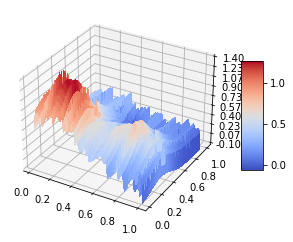

In [3]:
npoints = 100


# Make data.
x = np.sort(np.random.uniform(0, 1, npoints)) 
y = np.sort(np.random.uniform(0, 1, npoints)) 


x, y = np.meshgrid(x,y)


z = FrankeFunction(x, y) 
z = z + 0.1 * np.random.randn(z.shape[0])

surfaceplot(x,y,z)


In [4]:
n = 5


x = np.sort(np.random.uniform(0.0 , 1.0 , npoints)) 
y = np.sort(np.random.uniform(0.0 , 1.0 , npoints))


x, y = np.meshgrid(x,y)


X = create_X(x,y,n)




X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1,1), test_size=0.2)


betaOLS = OLSmethod(X_train , z_train)


print(f"The variance is {np.var(betaOLS)}")
print(np.std(betaOLS))



zpred = X_train@betaOLS
print("For the training data we get a MSE of")
printQ(z_train,zpred)


print("For the test data we get a MSE of")
ztilde = X_test@betaOLS
printQ(z_test,ztilde)



MSElist = []
R2list = []
for i in range(28):
    bootX,bootz = resample(X_train,z_train.reshape(-1,1))


    bootbetaOLS = OLSmethod(bootX,bootz)
    
    ypred = bootX @ bootbetaOLS
    MSElist.append(MSE(z_train,ypred))
    R2list.append(R2(bootz,ypred))
    




print(np.mean(MSElist))
print(np.mean(R2list))

The variance is 673.0531845489453
25.94326857874592
For the training data we get a MSE of
--------------------------------------------------------
MSE = |0.015287000203800947|, R2 = |0.8292449721547143|
--------------------------------------------------------

For the test data we get a MSE of
--------------------------------------------------------
MSE = |0.015491957534745832|, R2 = |0.8389387854228995|
--------------------------------------------------------

0.16404096767902457
0.8297528022358802


## For the scaled data

In [5]:
scaler = StandardScaler()

X_scale = scaler.fit_transform(X)
z_scaled = scaler.fit_transform(z)




X_strain, X_stest, z_strain, z_stest = train_test_split(X_scale, z_scaled.reshape(-1,1) , test_size = 0.2 )

betascaledOCS = np.linalg.pinv(X_strain.T@X_strain)@ X_strain.T @ z_strain
print(f"The variance of the scaled coefficients is {np.var(betascaledOCS)}\n")

zpreds = X_strain@betascaledOCS



print(f"Under we print the different values for MSE and R2")



print("For the scaled training data we get a MSE and R2 of:")
printQ(z_strain,zpreds)


print("For the scaled test data we get a MSE and R2 of: ")
ztilde = X_stest @ betascaledOCS

printQ(z_stest,ztilde)


The variance of the scaled coefficients is 639.6842176873566

Under we print the different values for MSE and R2
For the scaled training data we get a MSE and R2 of:
--------------------------------------------------------
MSE = |0.04274562634319645|, R2 = |0.9571593771064395|
--------------------------------------------------------

For the scaled test data we get a MSE and R2 of: 
--------------------------------------------------------
MSE = |0.04436127158239009|, R2 = |0.9560005033447061|
--------------------------------------------------------



## Task 2

The polynomial range is [0,12] 


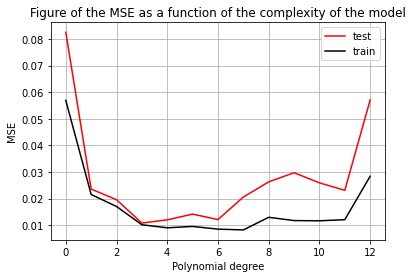

In [35]:
npoints = 18


# Make data.
x = np.sort(np.random.uniform(0, 1, npoints)) 
y = np.sort(np.random.uniform(0, 1, npoints)) 


x, y = np.meshgrid(x,y)


z = FrankeFunction(x, y) 
z = z + 0.1 * np.random.randn(z.shape[0])


n = 12

plotMSEcomplexity(x,y,z,n)